TO DO:
- Use matplotlib widget to plot MO
- Use UHF to calculate MO of atoms and molecule and construct MO diagrams
- Yrite wrapers for PySCF orbital analysis

This module allows the students to 
- visualize and analyse atomic and molecular orbitals
- build molecular diagrams.
- Calculate IP and EA using Koopman´s approximation.
- Link MO to chemical bon theory.

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf
from IPython.display import Image 

/Users/milaimkas/Teaching/Teaching_project/venv/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


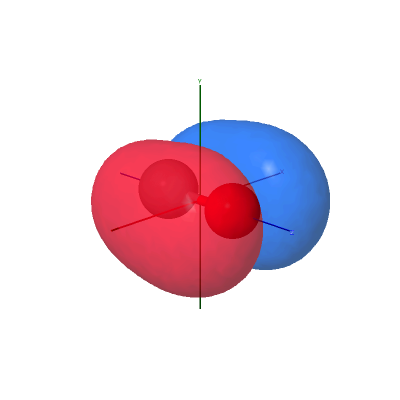

In [3]:
Image(filename='MO_orbitals/MO_CO/MO_5.png')

/var/folders/wj/fx7jsw2j3437zjvc4x852hzc0000gn/T/ipykernel_7710/2766328053.py:12: RuntimeWarning: invalid value encountered in true_divide
  Theta = numpy.arccos(Z / R)


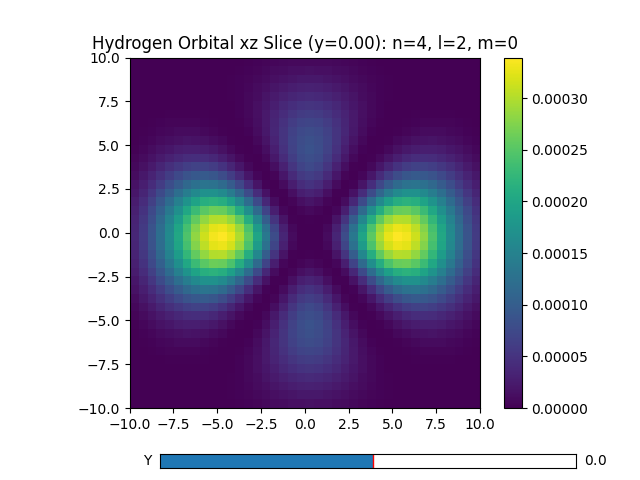

In [1]:
%matplotlib ipympl
import numpy
from matplotlib.widgets import Slider
import scipy.special
from scipy.special import sph_harm
import math
import matplotlib.pyplot as plt


def hydrogen_wf(n, l, m, X, Y, Z):
    R = numpy.sqrt(X ** 2 + Y ** 2 + Z ** 2)
    Theta = numpy.arccos(Z / R)
    Phi = numpy.arctan2(Y, X)

    rho = 2. * R / n
    s_harm = sph_harm(m, l, Phi, Theta)
    l_poly = scipy.special.genlaguerre(n - l - 1, 2 * l + 1)(rho)

    prefactor = numpy.sqrt((2. / n) ** 3 * math.factorial(n - l - 1) / (2. * n * math.factorial(n + l)))
    wf = prefactor * numpy.exp(-rho / 2.) * rho ** l * s_harm * l_poly
    wf = numpy.nan_to_num(wf)
    return wf


dz = 0.5
zmin = -10
zmax = 10
x = numpy.arange(zmin, zmax, dz)
y = numpy.arange(zmin, zmax, dz)
z = numpy.arange(zmin, zmax, dz)
X, Y, Z = numpy.meshgrid(x, y, z)

# Change these to change which orbital to plot
n = 4
l = 2
m = 0

data = hydrogen_wf(n, l, m, X, Y, Z)
data = abs(data) ** 2

R = numpy.sqrt(X ** 2 + Y ** 2 + Z ** 2)

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.15, bottom=0.15)
im = plt.imshow(data[int((0 - zmin) / dz), :, :], vmin=0, vmax=numpy.max(data), extent=[zmin, zmax, zmin, zmax])
plt.colorbar()
sli = Slider(plt.axes([0.25, 0.025, 0.65, 0.03]), "Y", z[0], z[len(z) - 1], valinit=0)
ax.set_title(
    "Hydrogen Orbital xz Slice (y=" + str("%.2f" % sli.val) + "): n=" + str(n) + ", l=" + str(l) + ", m=" + str(m))


def update(val):
    index = int((sli.val - zmin) / dz)
    im.set_data(data[index, :, :])
    ax.set_title(
        "Hydrogen Orbital xz Slice (y=" + str("%.2f" % sli.val) + "): n=" + str(n) + ", l=" + str(l) + ", m=" + str(m))


sli.on_changed(update)
plt.show()